# Combine Raw Datasets

In [3]:
import pandas as pd

mapping = {
  "Address": "address",
  "FLAG": "flag",
  "Avg min between sent tnx": "avgTimeBetweenSentTnx",
  "Avg min between received tnx": "avgTimeBetweenRecTnx",
  "Time Diff between first and last (Mins)": "lifetime",
  "Sent tnx": "sentTransactions",
  "Received Tnx": "receivedTransactions",
  "Number of Created Contracts": "createdContracts",
  "Unique Received From Addresses": "numUniqRecAddress",
  "Unique Sent To Addresses": "numUniqSentAddress",
  "min value received": "minValReceived",
  "max value received ": "maxValReceived",
  "avg val received": "avgValReceived",
  "min val sent": "minValSent",
  "max val sent": "maxValSent",
  "avg val sent": "avgValSent",
  "total transactions (including tnx to create contract": "totalTransactions",
  "total Ether sent": "totalEtherSent",
  "total ether received": "totalEtherReceived",
  "total ether sent contracts": "totalEtherSentContracts",
  "total ether balance": "totalEtherBalance",
}

df_1 = pd.read_csv('data/raw/eth_illicit_features.csv')
df_2 = pd.read_csv('data/raw/transaction_dataset.csv') \
    .drop(columns=['Unnamed: 0', 'Index'])

df_1 = df_1[mapping.values()]
df_2 = df_2.rename(columns=mapping)[mapping.values()]
df = pd.concat([df_1, df_2]).drop_duplicates(subset='address').reset_index(drop=True)
df.to_csv('data/processed/kaggle_transaction_dataset.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20302 entries, 0 to 20301
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address                  20302 non-null  object 
 1   flag                     20302 non-null  int64  
 2   avgTimeBetweenSentTnx    20302 non-null  float64
 3   avgTimeBetweenRecTnx     20302 non-null  float64
 4   lifetime                 20302 non-null  float64
 5   sentTransactions         20302 non-null  int64  
 6   receivedTransactions     20302 non-null  int64  
 7   createdContracts         20302 non-null  int64  
 8   numUniqRecAddress        20302 non-null  int64  
 9   numUniqSentAddress       20302 non-null  int64  
 10  minValReceived           20302 non-null  float64
 11  maxValReceived           20302 non-null  float64
 12  avgValReceived           20302 non-null  float64
 13  minValSent               20302 non-null  float64
 14  maxValSent            

## Add Centrality Score

In [3]:
account_df = pd.read_csv('data/processed/kaggle_transaction_dataset.csv')
address_mapping = pd.DataFrame(data={
    'address': account_df['address'], 
    'mapped_id': account_df['address'].index
})

transaction_df = pd.read_csv('data/queried/full_transactions.csv')
transaction_mapping = transaction_df \
    .merge(
        address_mapping, 
        left_on='address from', 
        right_on='address'
    ) \
    .merge(
        address_mapping, 
        left_on='address to', 
        right_on='address', 
        suffixes=('_from', '_to')
    )[['mapped_id_from', 'mapped_id_to']]

In [4]:
import networkx as nx

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for address in address_mapping['mapped_id']:
    G.add_node(address)

# Add edges to the graph
for _, row in transaction_mapping.iterrows():
    G.add_edge(row['mapped_id_from'], row['mapped_id_to'])

# Check the nodes and edges in the graph
print("Nodes:", G.nodes())
print("Edges:", G.edges())

Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [5]:
account_df['degree_centrality'] = nx.degree_centrality(G)
account_df['betweeness_centrality'] = nx.betweenness_centrality(G, k=5000)
account_df['eigenvector_centrality'] = nx.eigenvector_centrality_numpy(G)

account_df.to_csv('data/processed/kaggle_transaction_dataset_centrality.csv', index=False)

# Exploratory Data Analysis

In [22]:
import pandas as pd

df = pd.read_csv('data/processed/kaggle_transaction_dataset_centrality.csv')


## Correlation of features

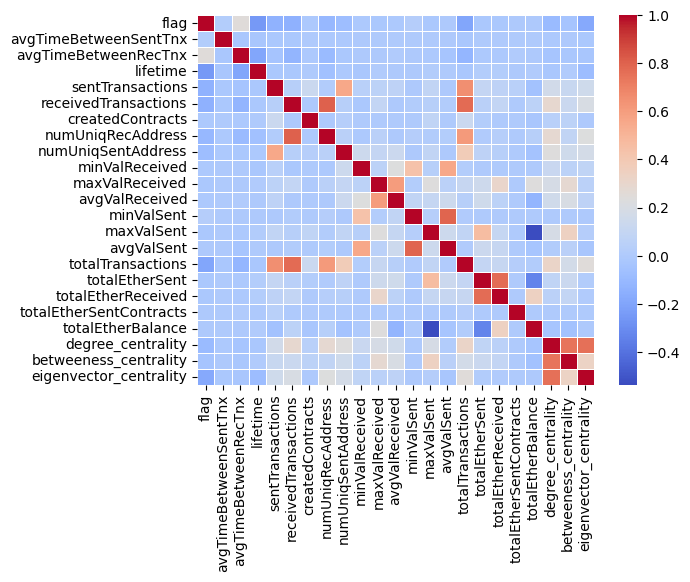

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.drop(columns='address').corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5)
plt.show()

In [24]:
df_num_corr = correlation_matrix['flag'][1:] 
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with FLAG:\n{}".format(len(golden_features_list), golden_features_list))

There is 0 strongly correlated values with FLAG:
Series([], Name: flag, dtype: float64)


## Distribution of features

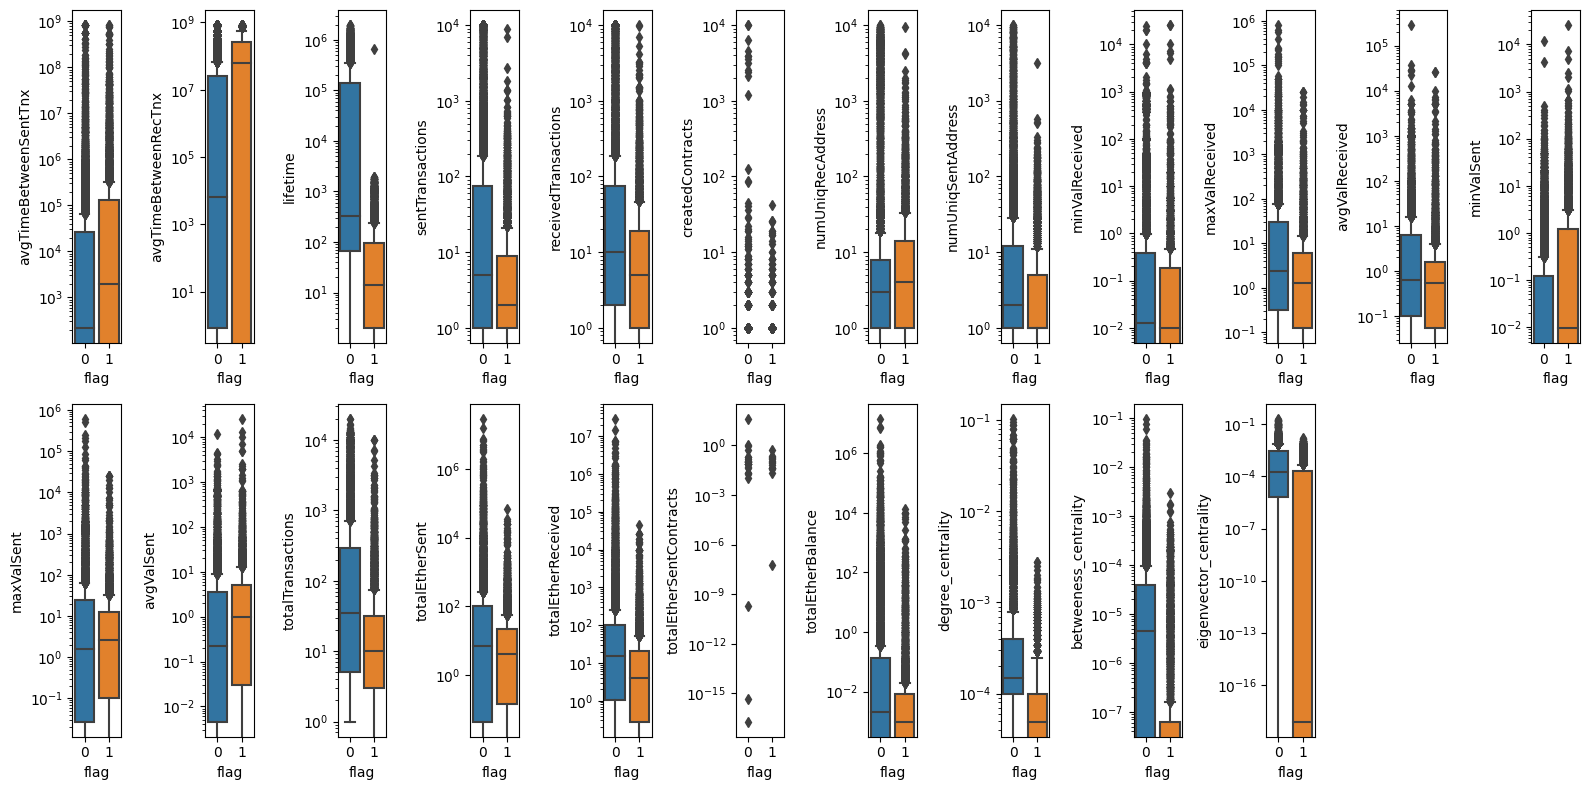

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select only the columns containing features
feature_columns = df.drop(columns=['address', 'flag']).columns

plt.figure(figsize=(16, 8))

# Create individual boxplots for each feature
for i, feature in enumerate(feature_columns):
    plt.subplot(2, len(feature_columns) // 2 + 1, i + 1)
    sns.boxplot(x='flag', y=feature, data=df)
    plt.yscale('log')

plt.tight_layout()
plt.show()